In [1]:
# ! pip install --user magic-impute

In [2]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
from utils import *
import pickle

In [3]:
# full_data = ad.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/cell_cycle/pipeline_outputs/single_cell_fibroblast/scanpy/processed.anndata.h5ad')
full_data = ad.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle_velocity.h5ad')
full_data.var['gene_name'] = full_data.var.index.copy()
full_data.obs['pred_phase'] = full_data.obs['phase']
full_data.shape

(7541, 21412)

In [4]:
for phase in ['G1', 'S', 'G2M']:
    phase_data = full_data[full_data.obs['phase'] == phase]
    print(np.sum(np.sum(phase_data.X, axis=0) != 0))

21082
20861
21012


In [5]:
population = ad.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/cell_cycle/pipeline_outputs/population_fib_sync/count_matrix/population_counts.h5ad')
population.obs.rename(columns={'transition': 'pred_phase'}, inplace=True)
population.var = population.var.set_index(population.var['gene_name'])
transitions = ['M/G1', 'G1/S']

/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/anndata/_core/anndata.py:774: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


# Specify options

In [6]:
genes = 'cell_cycle'  # ['cell_cycle', 'all']
phase_grouping = [['G1', 'S', 'G2M']]
# phase_grouping = [['G1', 'S'], ['G2M']]
# phase_grouping = [['G1'], ['S','G2M']]
# phase_grouping = [['G1'], ['S'], ['G2M']]
imputation = 'magic' #['magic', None]
layer = 'log_norm' # ['log_norm', 'norm'

In [7]:
prev = ad.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/cell_cycle/pipeline_outputs/single_cell_fibroblast/scanpy/processed.anndata.h5ad')
whitfield, go, seurat, kegg, liu = get_masks(prev)

/home/cstansbu/git_repositories/twincell_support/notebooks/rna_velocity/utils.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  whitfield_columns = adata.var.filter(like='whitfield').replace({'True': True, 'False': False})
/home/cstansbu/git_repositories/twincell_support/notebooks/rna_velocity/utils.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  whitfield_columns = adata.var.filter(like='whitfield').replace({'True': True, 'False': False})
/home/cstansbu/git_repositories/twincell_support/notebooks/rna_velocity/utils.py:8: FutureWarning: Down

### Construct a mask for which genes to consider

In [8]:
if genes == 'cell_cycle':
    prev_mask = np.logical_or.reduce([whitfield, go, seurat, kegg, liu])
    gene_list = prev.var[prev_mask]['gene_name'].values
    
    initial_gene_mask = full_data.var['gene_name'].isin(gene_list)
    cc_gene_names = full_data[:, full_data.var['gene_name'].isin(gene_list)].var_names
    population = population[:,population.var['gene_name'].isin(cc_gene_names)]
    initial_gene_mask = np.logical_and(initial_gene_mask, full_data.var_names.isin(population.var['gene_name'].values))
elif genes == 'all':
    initial_gene_mask = np.ones((full_data.shape[1],), dtype=bool)
else:
    raise ValueError('Please specify a valid selection of genes')

In [9]:
# break

In [10]:
gene_mask_names = full_data.var['gene_name'][initial_gene_mask].values.tolist()

### Construct a mask for which cells to consider

In [11]:
initial_cell_mask = [True] * len(full_data)

### Prune data according to selected cells and genes

In [12]:
adata1 = full_data[initial_cell_mask, initial_gene_mask]
adata1 = adata1[:, adata1.var['gene_name'].argsort()]
population = population[:, population.var['gene_name'].argsort()]
cat_data = ad.concat([adata1, population], axis=0, join='outer') # concatenate the population with the single cell
cat_data.var['gene_name'] = cat_data.var_names

/tmp/ipykernel_1656772/3764111421.py:4: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  cat_data = ad.concat([adata1, population], axis=0, join='outer') # concatenate the population with the single cell


## Preprocessing

### MAGIC

In [13]:
cat_data.X = cat_data.layers[layer]
if imputation == 'magic':
    processed_data = sc.external.pp.magic(cat_data, name_list=gene_mask_names, knn=20, copy=True, t=3)
else:
    processed_data = full_data[initial_cell_mask, initial_gene_mask].copy()

processed_data.layers['zscore'] = compute_zscore(processed_data.X.copy())

print(f'{processed_data.shape[0]} cells and {processed_data.shape[1]} genes')

7543 cells and 4565 genes


### Partition data if want to compute ptime over separate phase groupings

In [14]:
phase_data = [processed_data[processed_data.obs['phase'].isin(p) | processed_data.obs['phase'].isin(transitions)].copy() for p in phase_grouping]

### Recompute obsm fields with only data from certain phases

In [15]:
for adata in phase_data:
    n_dcs = 10
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=15)
    sc.tl.diffmap(adata, n_comps=n_dcs+1)
    sc.tl.umap(adata)

/nfs/turbo/umms-indikar/Cooper/conda_envs/scvelo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Various cell plots

### Full UMAP with each phase grouping

In [16]:
# fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
# # colormap = {'G1':'tab:blue', 'G2M':'tab:orange', 'S':'tab:green'}
# # colormap = {'G1':'tab:blue', 'G2M':'tab:green', 'S':'tab:orange'}
# for adata, phase, ax in zip(phase_data, phase_grouping, axs.flatten()):
#     sc.pl.umap(adata, color='phase', ax=ax, show=False) #, palette=[colormap[p] for p in phase])
#     ax.set_title(', '.join(phase))
# fig.tight_layout()

### UMAP with population-level data overlaid

In [17]:
# fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
# # colormap = {'G1':'tab:blue', 'G2M':'tab:orange', 'S':'tab:green'}
# # colormap = {'G1':'tab:blue', 'G2M':'tab:green', 'S':'tab:orange'}
# for adata, phase, ax in zip(phase_data, phase_grouping, axs.flatten()):
#     ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=2)
#     ax.set_title(', '.join(phase))
#     ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2')
#     for trans in transitions:
#         root = adata.obs['pred_phase']==trans
#         ax.scatter(adata.obsm['X_umap'][root, 0], adata.obsm['X_umap'][root, 1], edgecolor='k', s=100, marker='*',label=trans if phase==phase_grouping[-1] else None)
# axs[0,-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.tight_layout()


# norm_diff = np.linalg.norm(adata.X[adata.obs['pred_phase']=='M/G1'] - adata.X[adata.obs['pred_phase']=='G1/S'])
# print(f'Norm difference between transition points: {norm_diff}')

### UMAP with density contours

In [18]:
# fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
# for adata, phase, ax in zip(phase_data, phase_grouping, axs.flatten()):
#     # mask = adata.obs['pred_phase'] == phase
#     ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=1, label=phase)
#     ax.set_title(', '.join(phase))
#     sns.kdeplot(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], color='k', levels=7, ax=ax)
#     ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2')

## Diffusion pseudotime

### Euclidean root

In [19]:
# origins = []
# roots = []
# for adata in phase_data:
#     origins.append(np.mean(adata.obsm['X_umap'], axis=0))
#     # condition = adata.obs['leiden']=='1'
#     # condition = adata.obsm['X_umap'][:,0] < 8# origins[-1][0]
#     condition = True
#     roots.append(np.argmax((condition)*np.linalg.norm(adata.obsm['X_umap'] - origins[-1], axis=1)))
#     print(roots[-1])
#     # adata.uns['iroot'] = roots[-1]
#     # sc.tl.dpt(adata)

### PCA root

In [20]:
# roots_pca = []
# for adata in phase_data:
#     umap = ad.AnnData(adata.obsm['X_umap'])
#     sc.pp.pca(umap)
#     roots_pca.append(np.argmax(umap.obsm['X_pca'][:,0]))
#     print(roots_pca[-1])
# # adata.uns['iroot'] = roots_pca[-1]
# # sc.tl.dpt(adata)

### Root from population data (pseudotime computed here)

In [21]:
roots = []
transitions = ['M/G1', 'G1/S']
for adata, trans in zip(phase_data, transitions):
    roots.append(cat_data.obs['pred_phase'].tolist().index(trans))
    adata.uns['iroot'] = roots[-1]
    sc.tl.dpt(adata)
    print(trans)
print(roots)

M/G1
[7542]


### UMAP with different roots overlaid

In [22]:
# fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
# for adata, phase, rel_origin, root, root_pca, ax in zip(phase_data, phase_grouping, origins, roots, roots_pca, axs.flatten()):
    
#     umap_coords = adata.obsm['X_umap']
    
#     ax.scatter(umap_coords[:,0], umap_coords[:,1], s=1)
#     ax.scatter(rel_origin[0], rel_origin[1], s=50, color='yellow', edgecolor='black', 
#                 linewidth=0.5, marker='*', label='Mean')
#     ax.scatter(umap_coords[root, 0], umap_coords[root, 1], 
#                 color='tab:orange', s=10, linewidth=0.5, edgecolor='k', label='Euc. Root')
#     ax.scatter(umap_coords[root_pca, 0], umap_coords[root_pca, 1], marker='s',
#                 color='tab:green', s=10, linewidth=0.5, edgecolor='k', label='PCA Root')
#     ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2')
#     ax.set_title(', '.join(phase))
    
# axs[0,-1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

### UMAP with pseudotime

Text(0.5, 1.0, 'Pseudotime')

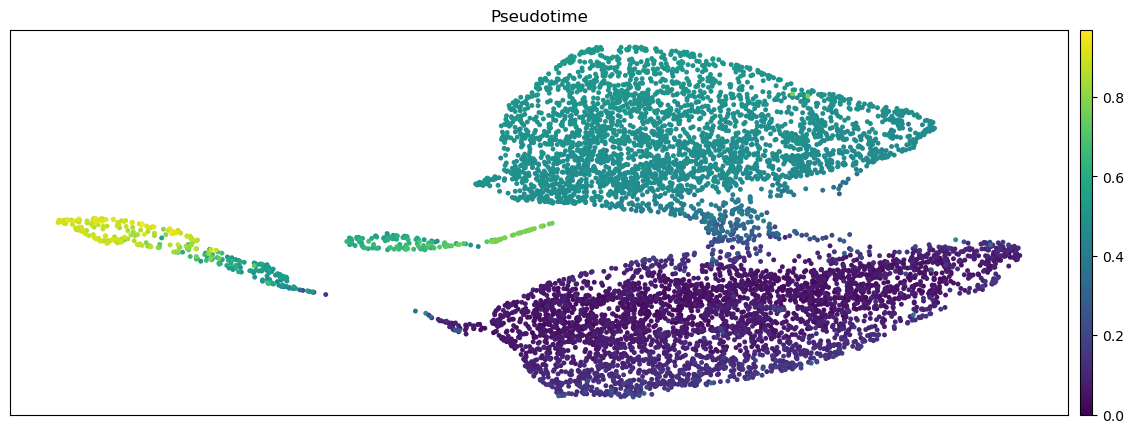

In [23]:
fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
for adata, ax in zip(phase_data, axs.flatten()):
    sc.pl.umap(adata, color=['dpt_pseudotime'], ax=ax, show=False, s=50)
plt.xlabel("")
plt.ylabel("")
plt.title('Pseudotime')

### Diffusion coordinates with pseudotime

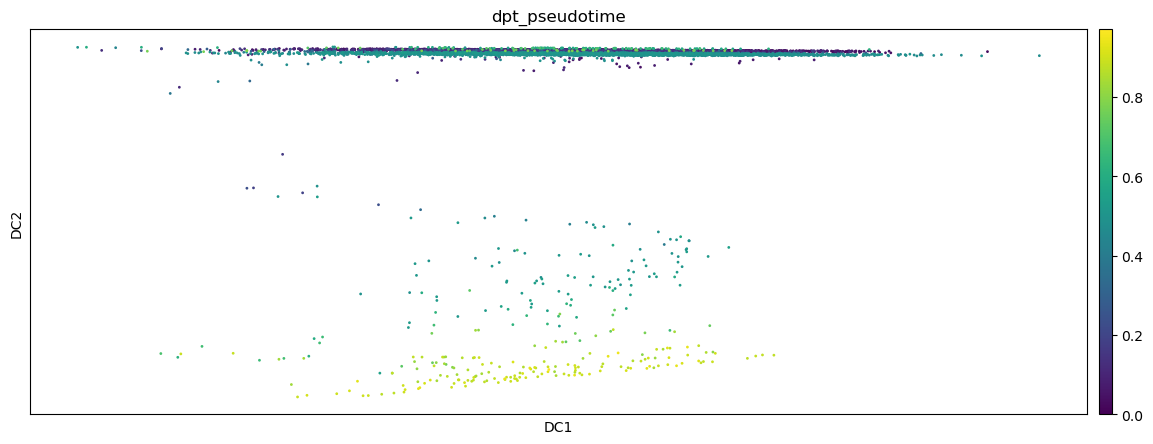

In [24]:
fig, axs = plt.subplots(1, len(phase_data), figsize=(15, 5), squeeze=False)
for adata, ax in zip(phase_data, axs.flatten()):
    sc.pl.diffmap(adata, color=['dpt_pseudotime'], ax=ax, show=False)

## Gene trajectories

### Sort cells by pseudotime

In [25]:
# Sort the data by pseudotime
for ii in range(len(phase_data)):
    sorted_indices = phase_data[ii].obs.sort_values(by='dpt_pseudotime').index
    phase_data[ii] = phase_data[ii][sorted_indices]
    # phase_data[ii].obs['order'] = np.arange(0, phase_data[ii].shape[0])

### Define the time axis

In [26]:
# Compute the time lengths of each phase grouping

phase_labels = ['G1', 'S', 'G2M']
time = [12, 6, 4]

# Create a dictionary mapping phase labels to time values
time_dict = dict(zip(phase_labels, time))

# Initialize the list with zero as the first element
time_partition = np.zeros((len(phase_grouping)+1,), dtype=int)

# Calculate the sum of time components for each group in phase
for ii, p in enumerate(phase_grouping):
    time_sum = sum(time_dict[label] for label in p)
    time_partition[ii+1] = time_sum

### Select genes and plot trajectories

(14, 7541)


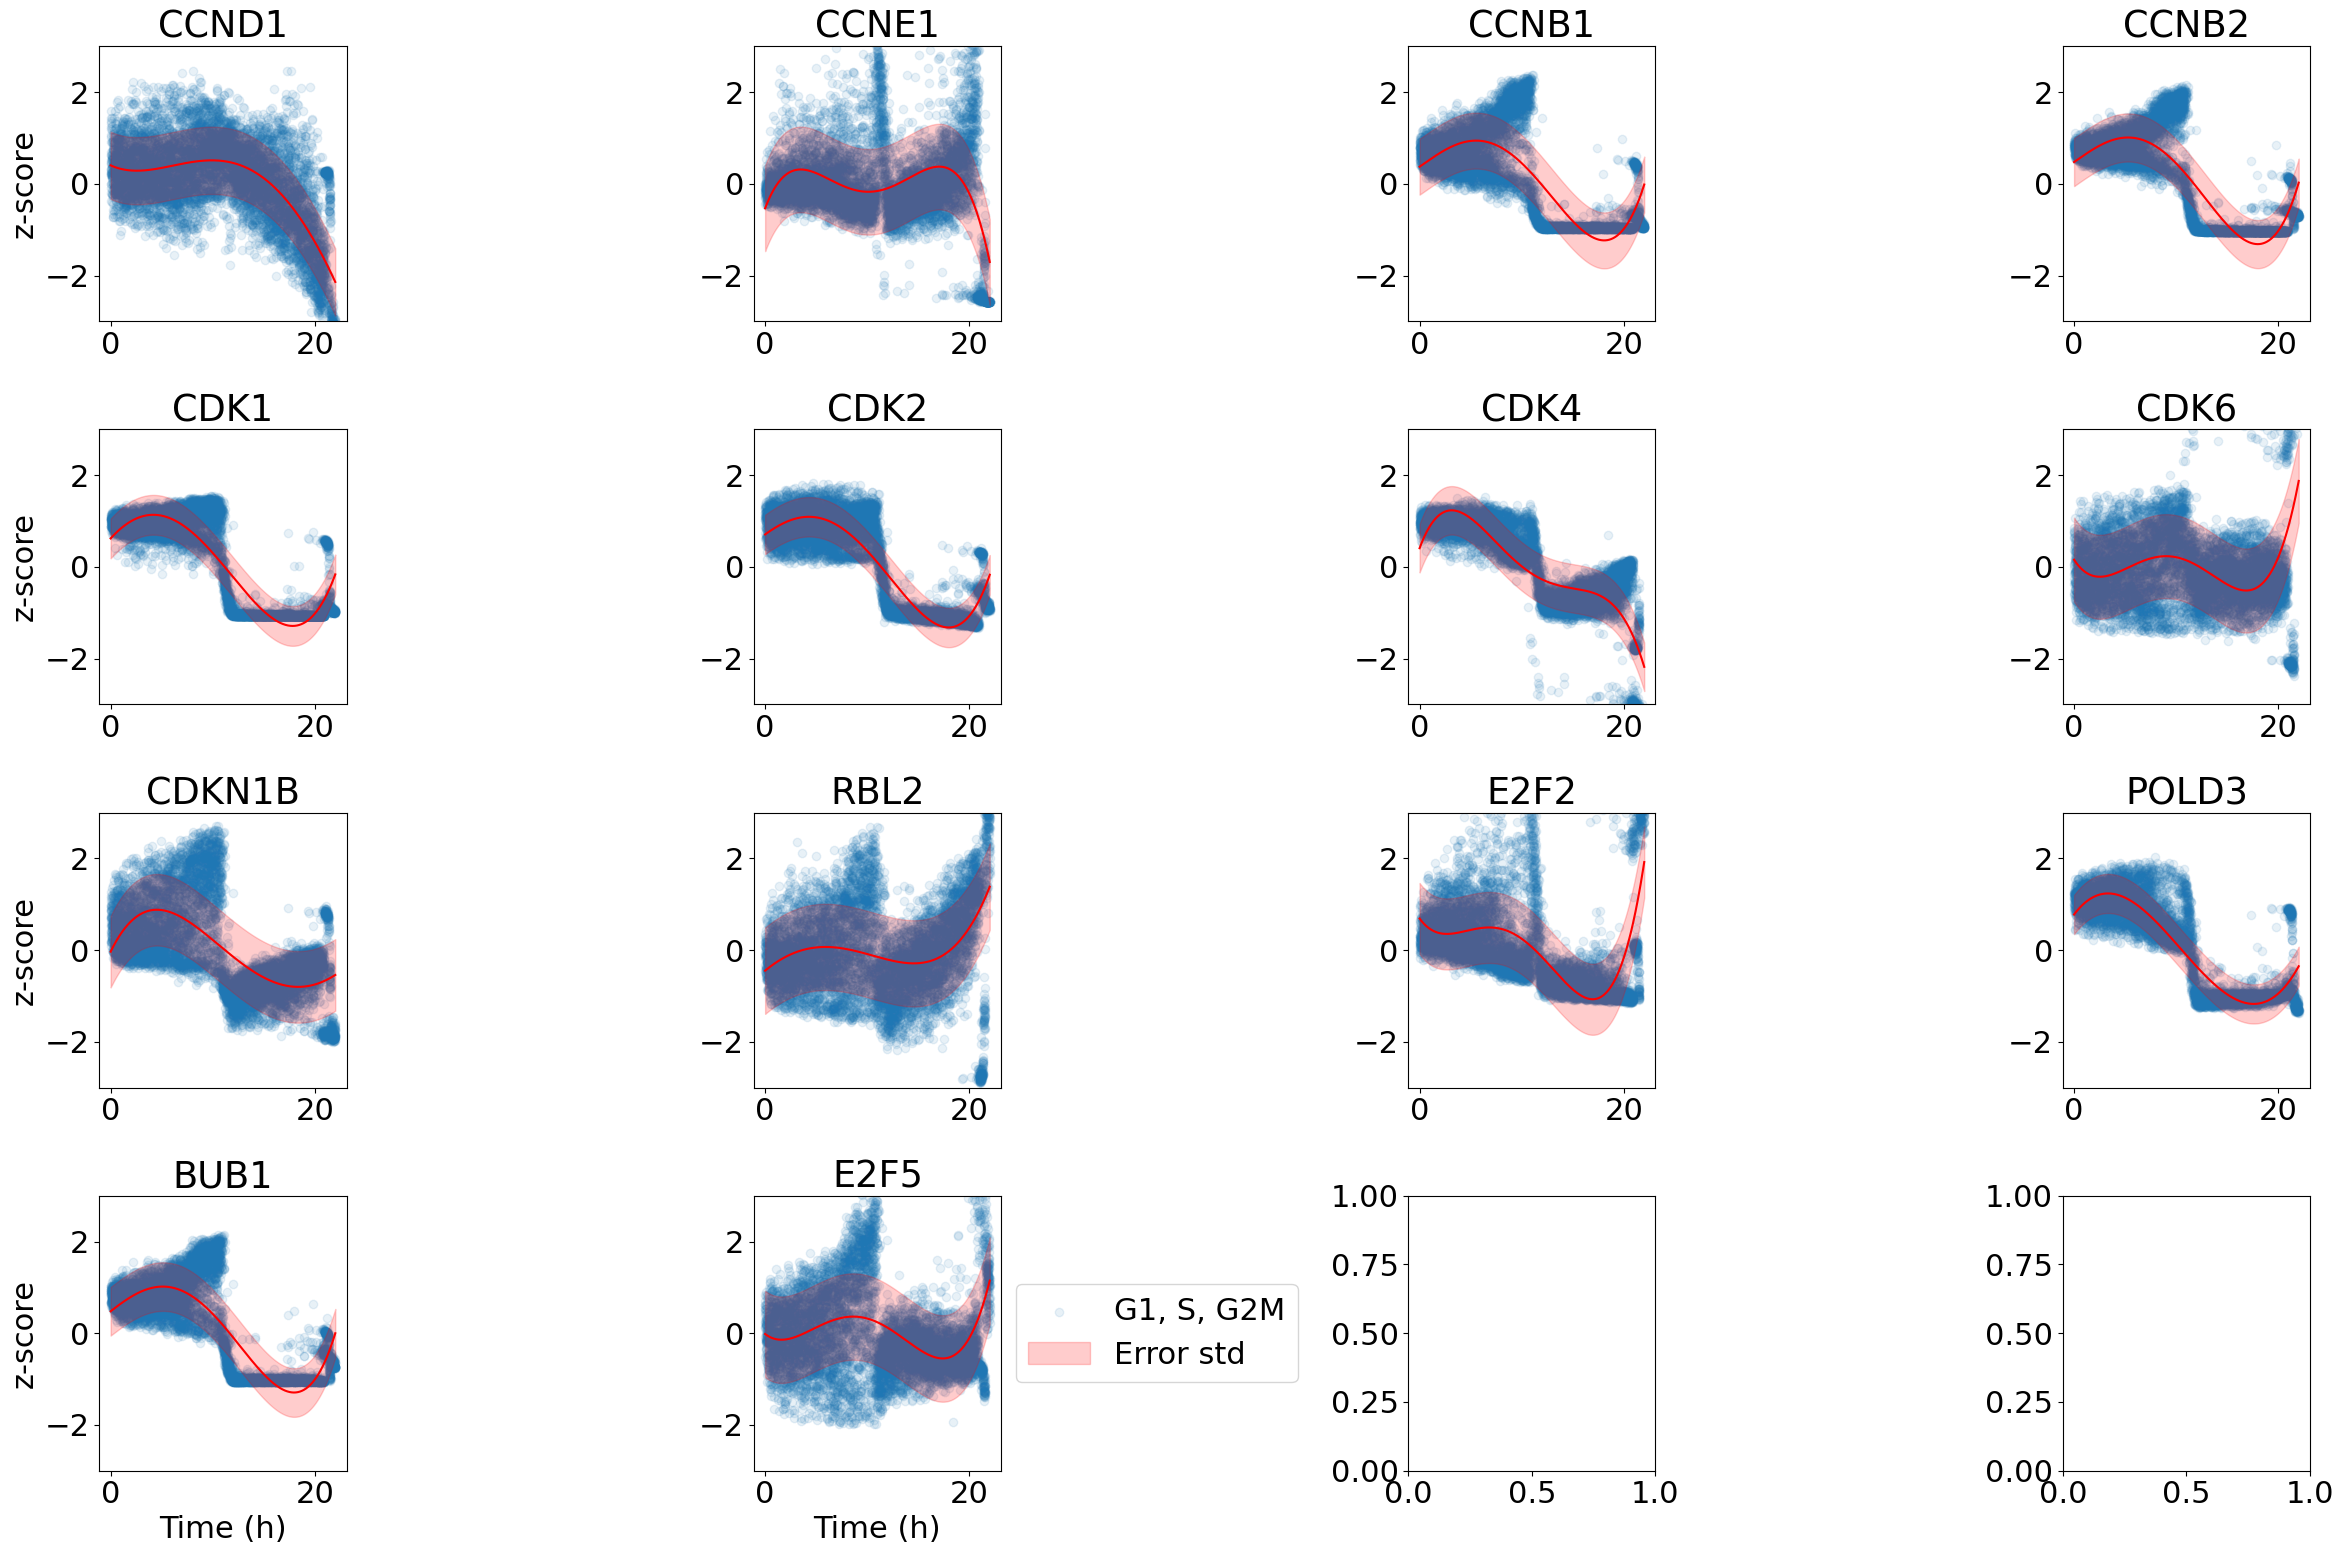

In [30]:
import matplotlib
font = {'size'   : 22}
matplotlib.rc('font', **font)

degree = 4
xaxis = 'order'
zscore=True

# gene_names = ['CCND1', 'CCNE1']
# genes found in paper
# gene_names = ['CCNE1', 'E2F1', 'PCNA', 'CNNB1', 'CCND1', 'CDT1', 'CDH1', 'H2AX', 'CDK2', 'CDK4', 'CDK6']

# genes that are found across 9 references
# gene_names = ['DEPDC1', 'HMMR', 'UNG', 'POLD3', 'TPX2', 'BIRC5', 'CDC6', 'E2F1', 'CDCA3', 'TTK', 'SFPQ', 'NEK2', 'GPSM2', 'CKS2']
# gene_names = ['TOP2A', 'PCNA', 'CCNB1', 'CDCA8', 'TROAP', 'CKAP2', 'KIF23', 'KIF11', 'CENPE', 'KIF2C', 'CCNA2']
# gene_names = ['MKI67', 'CCNB2', 'CCNF', 'RFC4', 'SLBP', 'HMGB2', 'PTTG1', 'PLK1', 'BUB1', 'UBE2C', 'CCNE2']

# gene_names = ['CCNE1', 'CCND1', 'CDK2', 'CDK4', 'CDK6', 'DEPDC1', 'POLD3', 'TPX2', 'TTK', 'GPSM2']#, 'CKS2', 'TOP2A', 'CCNB1', 'CDCA8', 'TROAP', 'KIF23', 'KIF11', 'MKI67', 'CENPE', 'CCNA2', 'CCNB2', 'RFC4', 'SLBP', 'BUB1', 'CCNE2']
gene_names = ['CCND1', 'CCNE1', 'CCNA1', 'CCNB1', 'CCNB2', 'CDK1', 'CDK2', 'CDK4', 'CDK6', 'CDKN1B', 'RBL2', 'E2F2', 'POLD3', 'BUB1', 'E2F4', 'E2F5']

# whitfield_G1S = full_data.var['gene_name'][whitfield].tolist()
# gene_names = whitfield_G1S

ncols=4
yhat, gene_names = plot_gene_trajectories(phase_data, gene_names, phase_grouping, degree, xaxis, time_partition, zscore=zscore, ncols=ncols)
print(yhat.shape)

### Plot the heatmap of selected gene trajectories

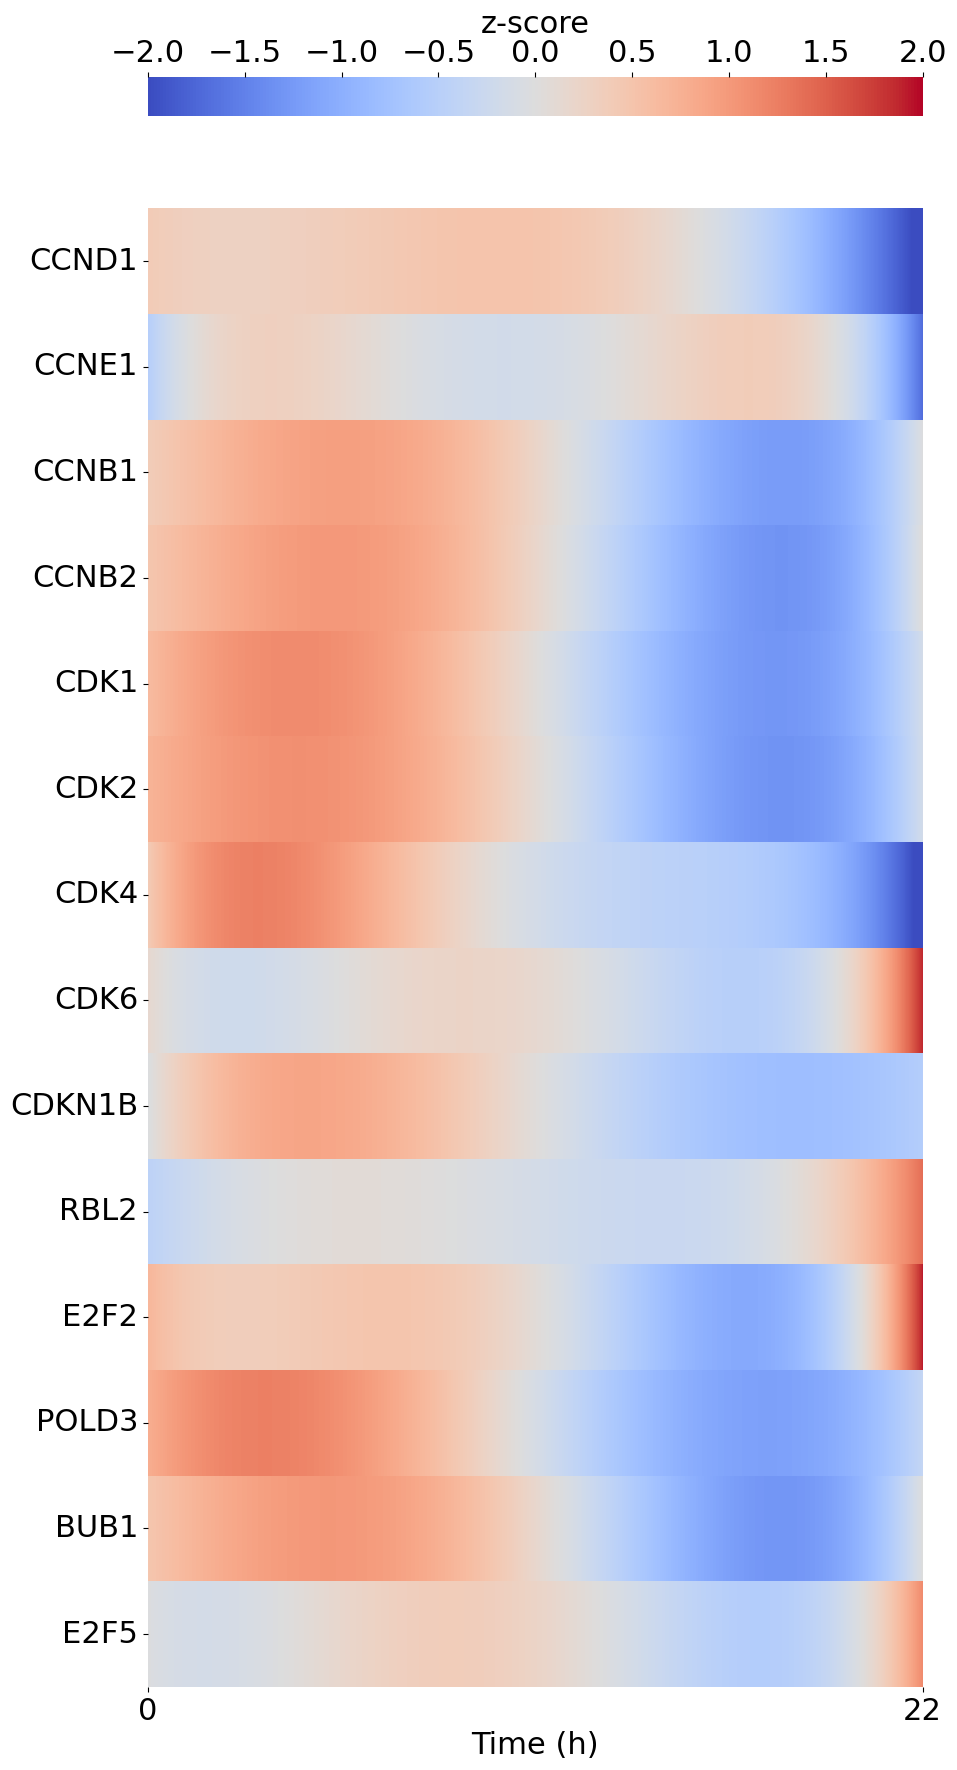

In [28]:
df = pd.DataFrame(yhat, columns=np.linspace(0, 22, yhat.shape[1], dtype=int),
                         index=gene_names)
plt.figure(figsize=(10,24))
ax = sns.heatmap(df, cmap='coolwarm', cbar=True, vmin=-2, vmax=2, cbar_kws={'label': 'z-score' if zscore else 'Gene expression', 'location': "top", 'use_gridspec': False})
ax.set_xticks([0, len(df.columns) - 1])
ax.set_xticklabels([df.columns[0], df.columns[-1]])
plt.xticks(rotation=0)
plt.xlabel('Time (h)');
# plt.xlabel('z-score' if zscore else 'Gene expression');

In [29]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Gene trajectories with binning instead of polynomial fit

In [ ]:
yhat = plot_gene_trajectories(phase_data, gene_names, phase_grouping, degree, xaxis, time_partition, zscore=zscore, bin=True)

# Some processing before saving a h5ad for learning dynamics

In [ ]:
orig_data = phase_data[0][np.logical_not(phase_data[0].obs['cell'].isna())].copy()
nan_mask = np.logical_not(full_data.obs['cell'].isna())
cluster_mask = np.logical_or(full_data.obs['leiden'] == '0', full_data.obs['leiden'] == '1')
print(np.sum(np.logical_and(nan_mask, cluster_mask)))
print(orig_data.shape)
filtered_data = full_data[np.logical_and(nan_mask, cluster_mask)].copy()
print(np.any(filtered_data.obs['cell'].isna()))
print(np.any(orig_data.obs['cell'].isna()))

In [ ]:
filtered_data = filtered_data[orig_data.obs['cell'].index].copy()
filtered_data.obs['dpt_pseudotime'] = orig_data.obs['dpt_pseudotime'].copy()
filtered_data = filtered_data[filtered_data.obs.sort_values(by='dpt_pseudotime').index, :].copy()

In [ ]:
print(np.max(orig_data.obs['dpt_pseudotime']))
print(np.max(filtered_data.obs['dpt_pseudotime']))

In [ ]:
filtered_data = sc.external.pp.magic(filtered_data, knn=20, copy=True, t=3)

### Visualize pseudotime by phase prediction for a given gene

In [ ]:
gene = 'CCNE1'
for phase in ['G1', 'S', 'G2M']:
    mask = filtered_data.obs['pred_phase'] == phase
    plt.scatter(filtered_data[mask].obs['dpt_pseudotime'], filtered_data.X[mask, filtered_data.var['gene_name']==gene])
plt.ylabel('Expression')
plt.xlabel('Pseudotime')
plt.title(gene)

In [ ]:
# filtered_data.write_h5ad(save_path)